In [11]:
# Imports & Parameters
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
START_DATE = '2020-01-01'
TICKERS = [
    'BTC-USD', 'ETH-USD', 
    #'XRP-USD', 'BNB-USD', 'SOL-USD', 
    #'TRX-USD', 'ADA-USD', 'DOGE-USD', 'ZEC-USD', 'LINK-USD'
]

SUB_PLOTS_X = 1
SUB_PLOTS_Y = 2

In [12]:
# Download data for all tickers
data = yf.download(TICKERS, start=START_DATE, auto_adjust=True, progress=False)

# Calculate returns for each ticker
returns = data['Close'].pct_change()

# Calculate log returns
log_returns = np.log(data['Close'] / data['Close'].shift(1))

# Add multi-level column names to returns DataFrames
returns.columns = pd.MultiIndex.from_product([['Returns'], returns.columns])
log_returns.columns = pd.MultiIndex.from_product([['LogReturns'], log_returns.columns])

# Add Day of the Week column - FIX: Use Series instead of DataFrame constructor
day_of_week = pd.Series(data.index.day_name(), index=data.index, name='DayOfWeek')
day_of_week = day_of_week.to_frame()
day_of_week.columns = pd.MultiIndex.from_product([['DayOfWeek'], ['DayOfWeek']])

# Concatenate with original data
data = pd.concat([data, returns, log_returns, day_of_week], axis=1)

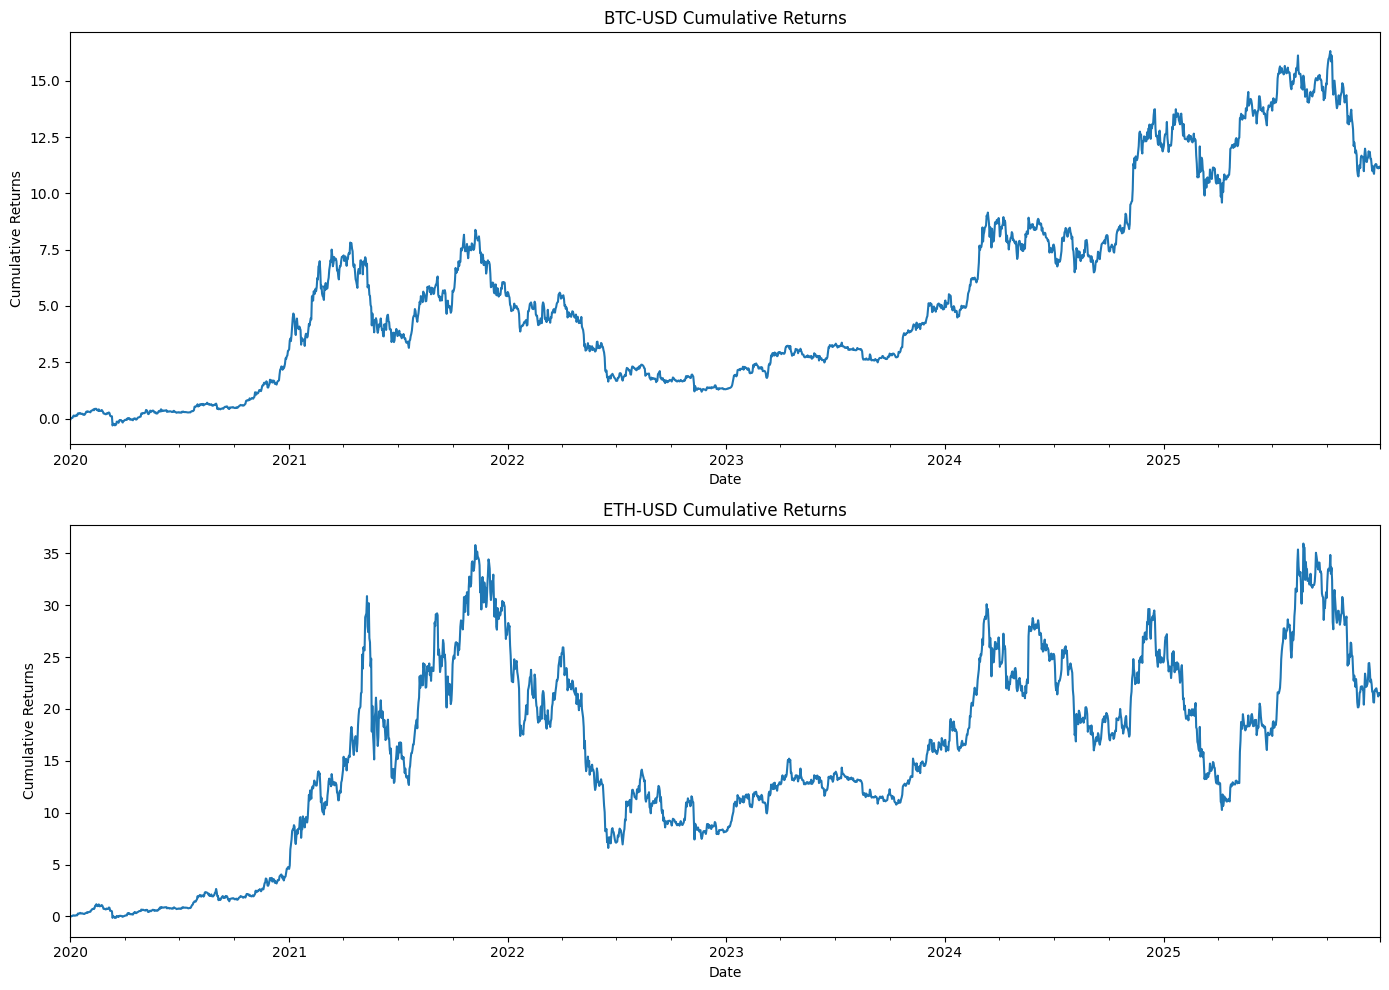

         Annualized Return  Annualized Volatility  Sharpe Ratio  Max Drawdown
BTC-USD           0.606229               0.610018      0.993789     -0.766346
ETH-USD           0.857793               0.817036      1.049884     -0.793512


In [13]:
# Plot cumulative returns and display summary statistics - annualized returns and volatility, Sharpe ratio and drawdown

cumulative_returns = (1 + data['Returns']).cumprod() - 1

fig, axes = plt.subplots(SUB_PLOTS_Y, SUB_PLOTS_X, figsize=(14, 10))
axes = axes.flatten()

for idx, ticker in enumerate(TICKERS):
    cumulative_returns[ticker].plot(ax=axes[idx], title=f'{ticker} Cumulative Returns')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Cumulative Returns')

plt.tight_layout()
plt.show()

# Calculate and display summary statistics
trading_days = 365  # Crypto markets trade 365 days a year

summary_stats = pd.DataFrame(index=TICKERS)

for ticker in TICKERS:
    returns_series = data['Returns'][ticker]
    
    # Annualized returns
    annualized_return = returns_series.mean() * trading_days
    
    # Annualized volatility
    annualized_volatility = returns_series.std() * np.sqrt(trading_days)
    
    # Sharpe ratio
    sharpe_ratio = annualized_return / annualized_volatility
    
    # Maximum drawdown
    cumulative = (1 + returns_series).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    
    summary_stats.loc[ticker, 'Annualized Return'] = annualized_return
    summary_stats.loc[ticker, 'Annualized Volatility'] = annualized_volatility
    summary_stats.loc[ticker, 'Sharpe Ratio'] = sharpe_ratio
    summary_stats.loc[ticker, 'Max Drawdown'] = max_drawdown

print(summary_stats.to_string())

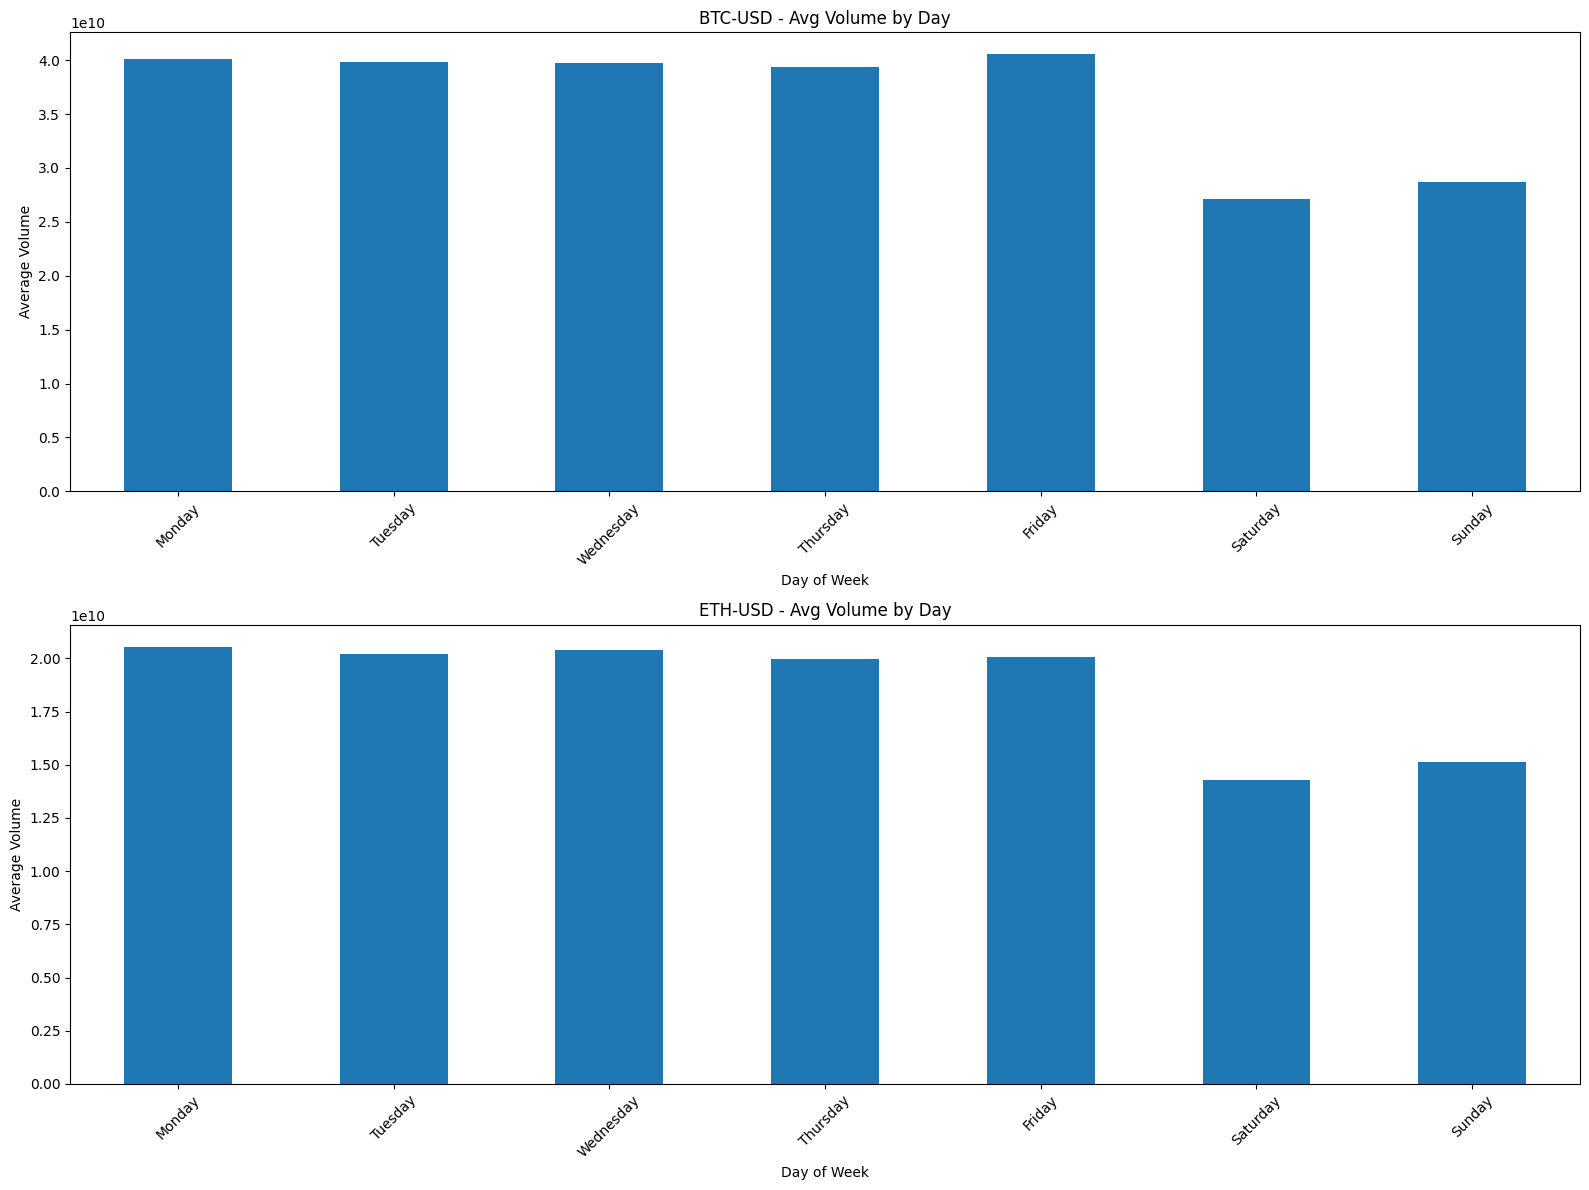

In [14]:
# Calculate average volume per day of the week for each asset

# Create a DataFrame to store average volume by day of week
volume_by_day = pd.DataFrame(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

for ticker in TICKERS:
    # Get volume data for this ticker
    volume_data = data['Volume'][ticker].copy()
    
    # Create a temporary DataFrame with volume and day of week
    temp_df = pd.DataFrame({
        'Volume': volume_data,
        'DayOfWeek': data[('DayOfWeek', 'DayOfWeek')]
    })
    
    # Calculate average volume by day of week
    avg_volume = temp_df.groupby('DayOfWeek')['Volume'].mean()
    
    # Add to results DataFrame
    volume_by_day[ticker] = avg_volume

# Reorder rows to start with Monday
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
volume_by_day = volume_by_day.reindex(day_order)

# Create a visualization
fig, axes = plt.subplots(SUB_PLOTS_Y, SUB_PLOTS_X, figsize=(16, 12))
axes = axes.flatten()

for idx, ticker in enumerate(TICKERS):
    volume_by_day[ticker].plot(kind='bar', ax=axes[idx], title=f'{ticker} - Avg Volume by Day')
    axes[idx].set_xlabel('Day of Week')
    axes[idx].set_ylabel('Average Volume')
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

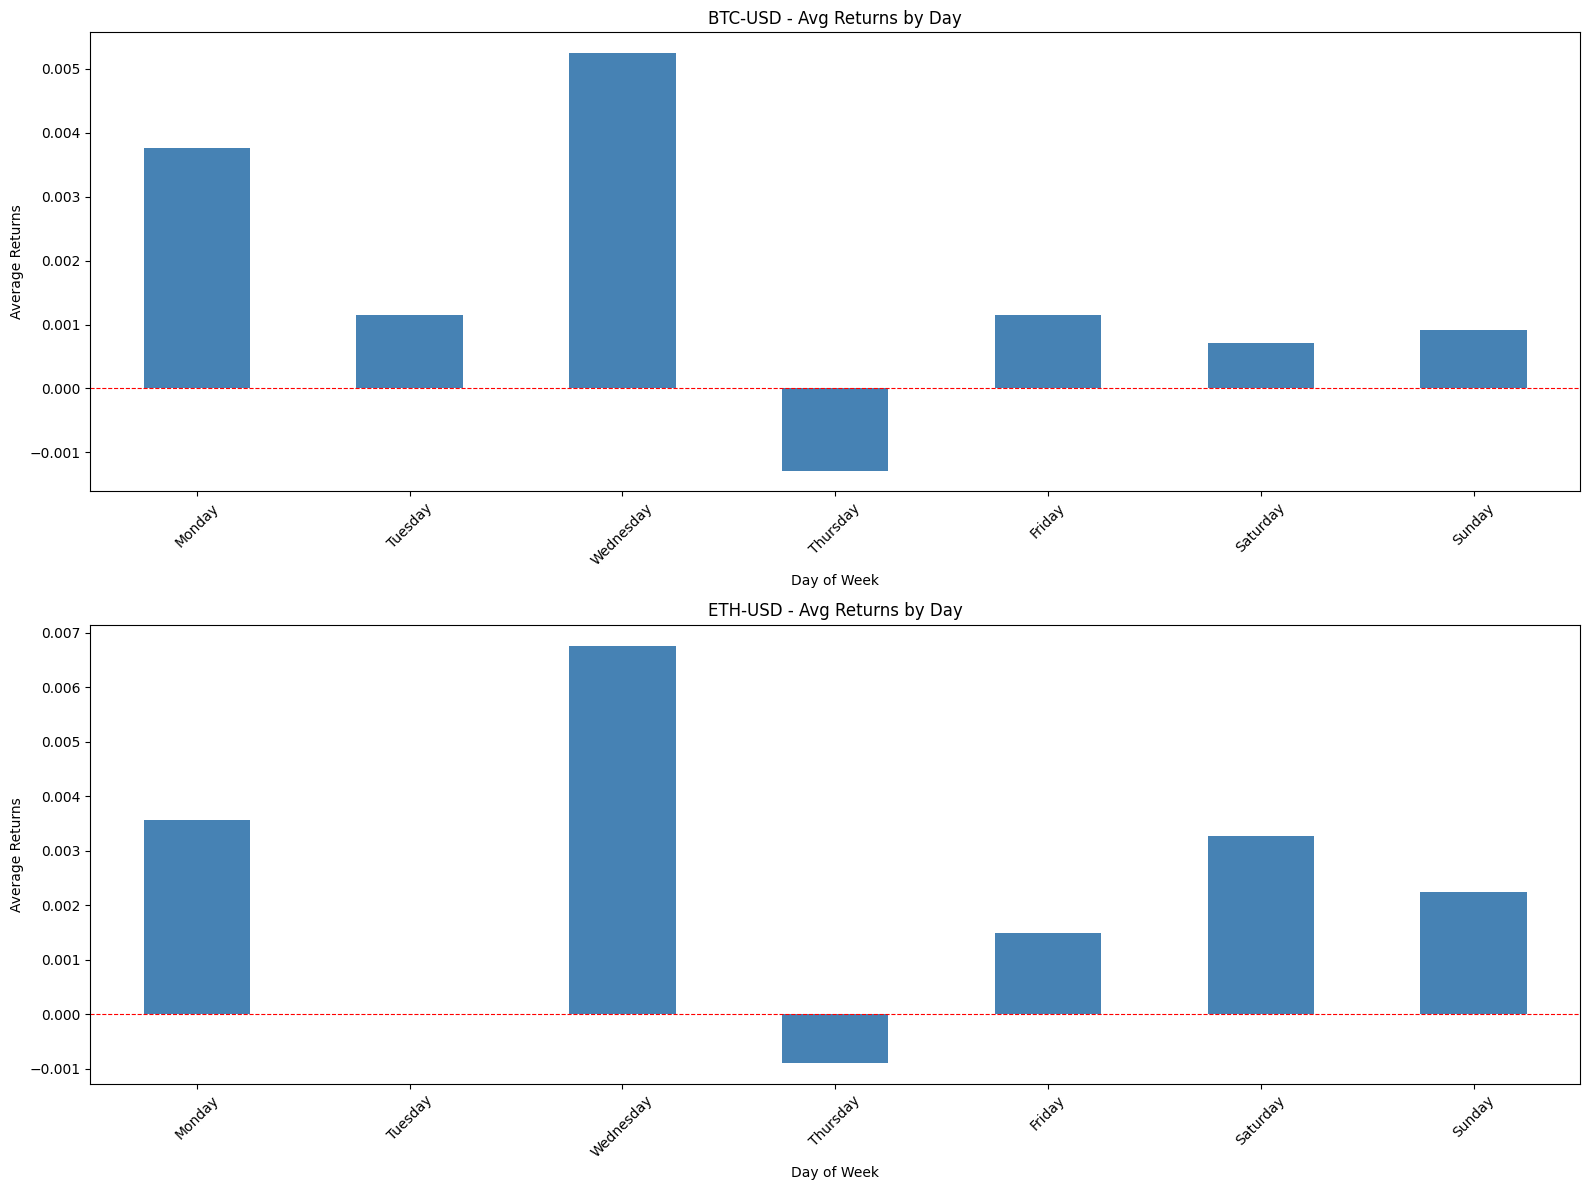

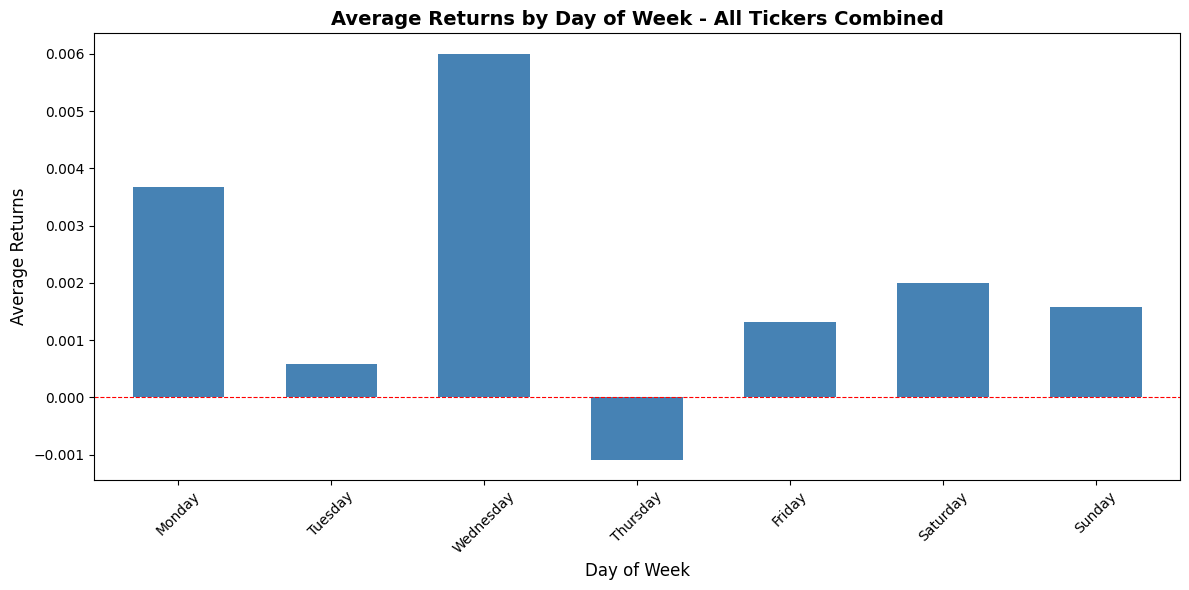

In [15]:
# Calculate average returns by day of week for each ticker
returns_by_day = pd.DataFrame(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

for ticker in TICKERS:
    # Get returns data for this ticker
    returns_data = data['Returns'][ticker].copy()
    
    # Create a temporary DataFrame with returns and day of week
    temp_df = pd.DataFrame({
        'Returns': returns_data,
        'DayOfWeek': data[('DayOfWeek', 'DayOfWeek')]
    })
    
    # Calculate average returns by day of week
    avg_returns = temp_df.groupby('DayOfWeek')['Returns'].mean()
    
    # Add to results DataFrame
    returns_by_day[ticker] = avg_returns

# Reorder rows to start with Monday
returns_by_day = returns_by_day.reindex(day_order)

# Create individual plots for each ticker
fig, axes = plt.subplots(SUB_PLOTS_Y, SUB_PLOTS_X, figsize=(16, 12))
axes = axes.flatten()

for idx, ticker in enumerate(TICKERS):
    returns_by_day[ticker].plot(kind='bar', ax=axes[idx], title=f'{ticker} - Avg Returns by Day', color='steelblue')
    axes[idx].set_xlabel('Day of Week')
    axes[idx].set_ylabel('Average Returns')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].axhline(y=0, color='red', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.show()

# Create a combined plot showing the average returns across all tickers by day of week
average_returns_all = returns_by_day.mean(axis=1)

fig, ax = plt.subplots(figsize=(12, 6))

average_returns_all.plot(kind='bar', ax=ax, color='steelblue', width=0.6)
ax.set_title('Average Returns by Day of Week - All Tickers Combined', fontsize=14, fontweight='bold')
ax.set_xlabel('Day of Week', fontsize=12)
ax.set_ylabel('Average Returns', fontsize=12)
ax.axhline(y=0, color='red', linestyle='--', linewidth=0.8)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Period: 2020-2022



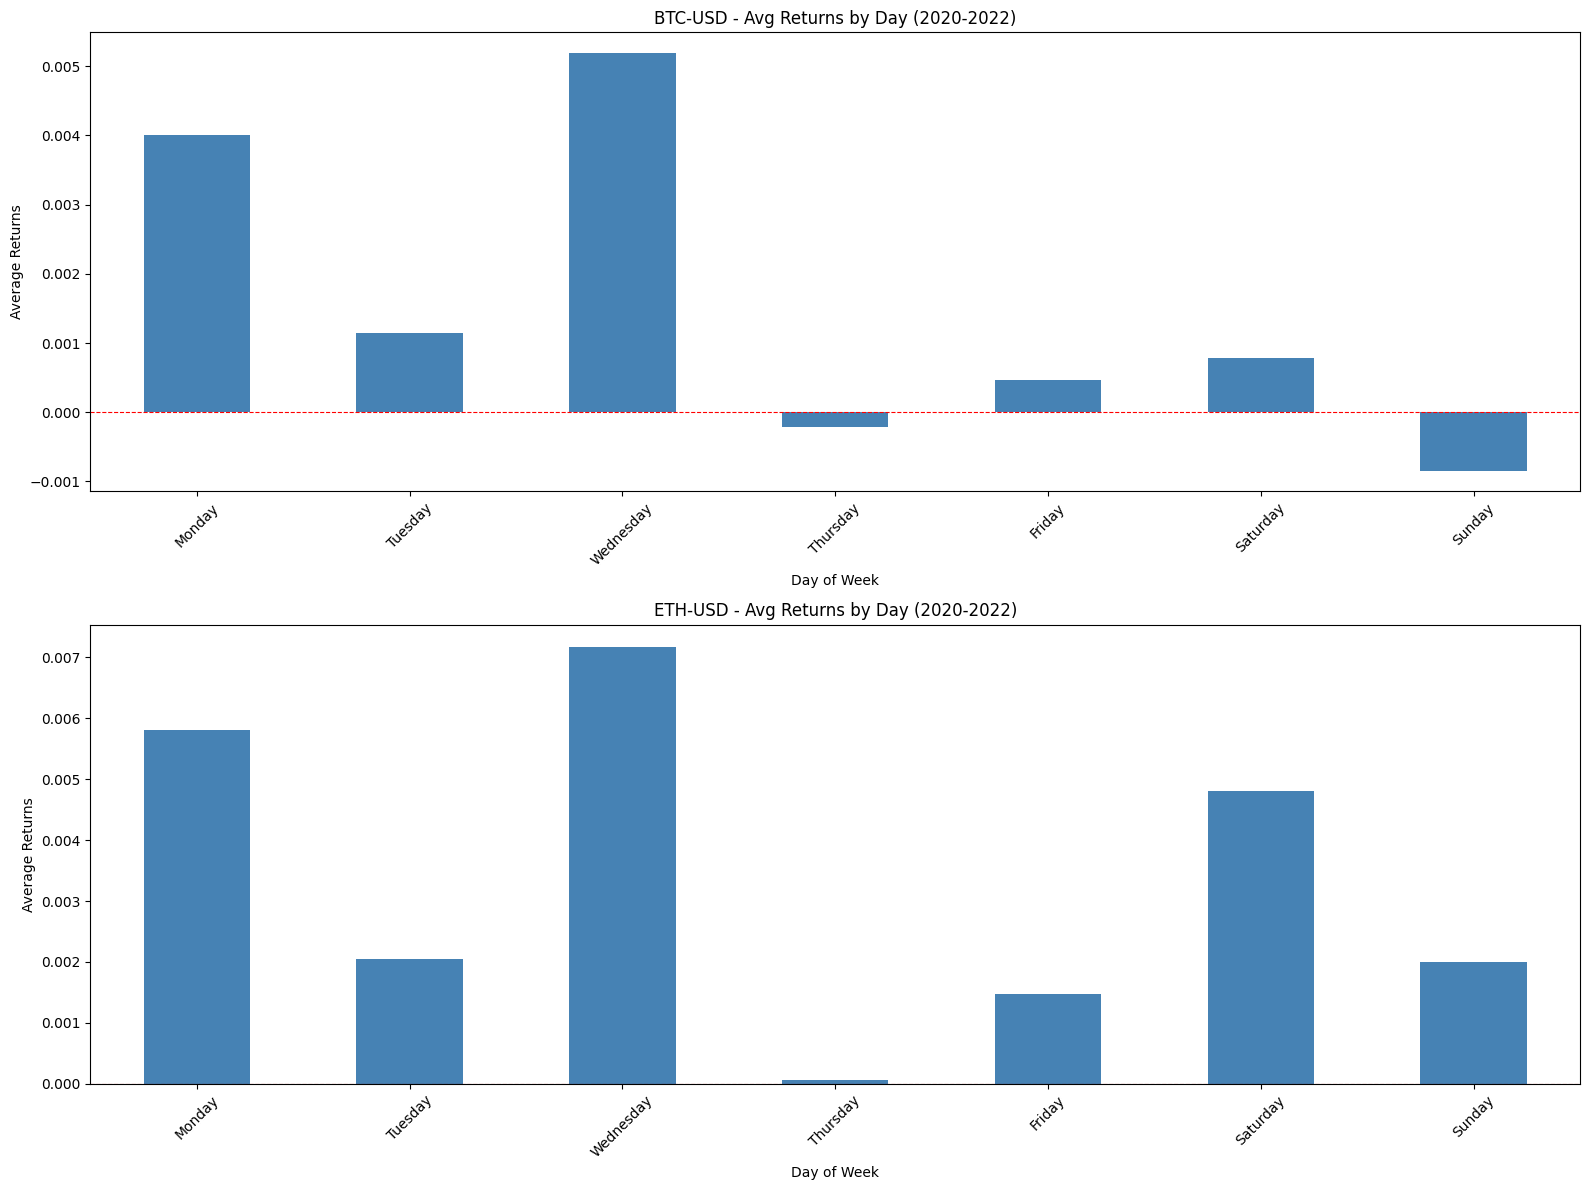

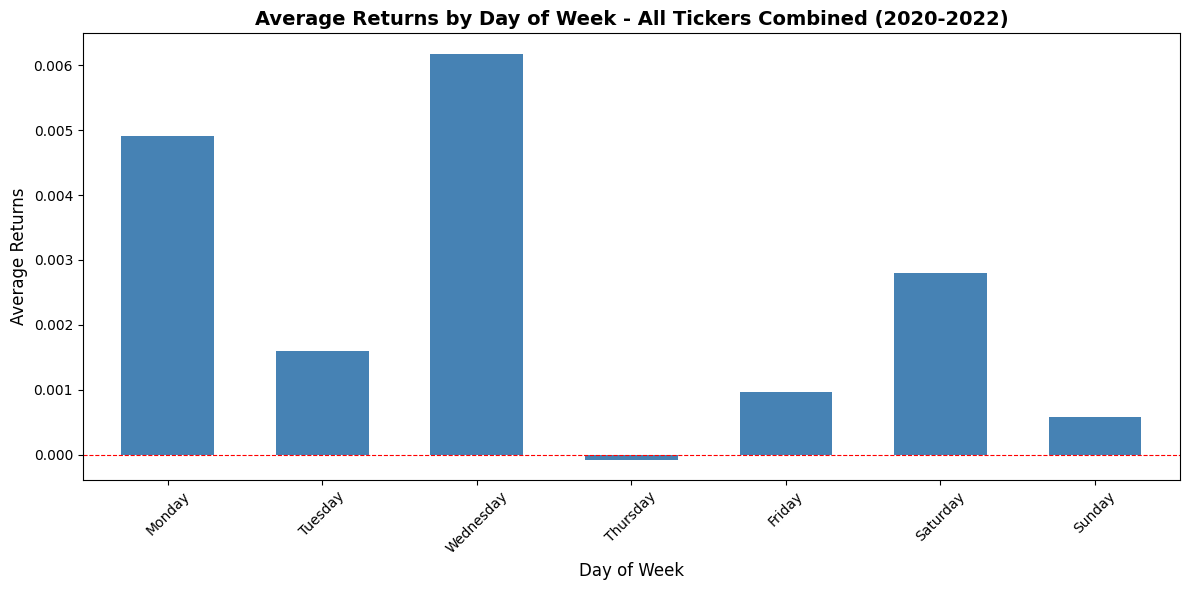


Period: 2023-Onward



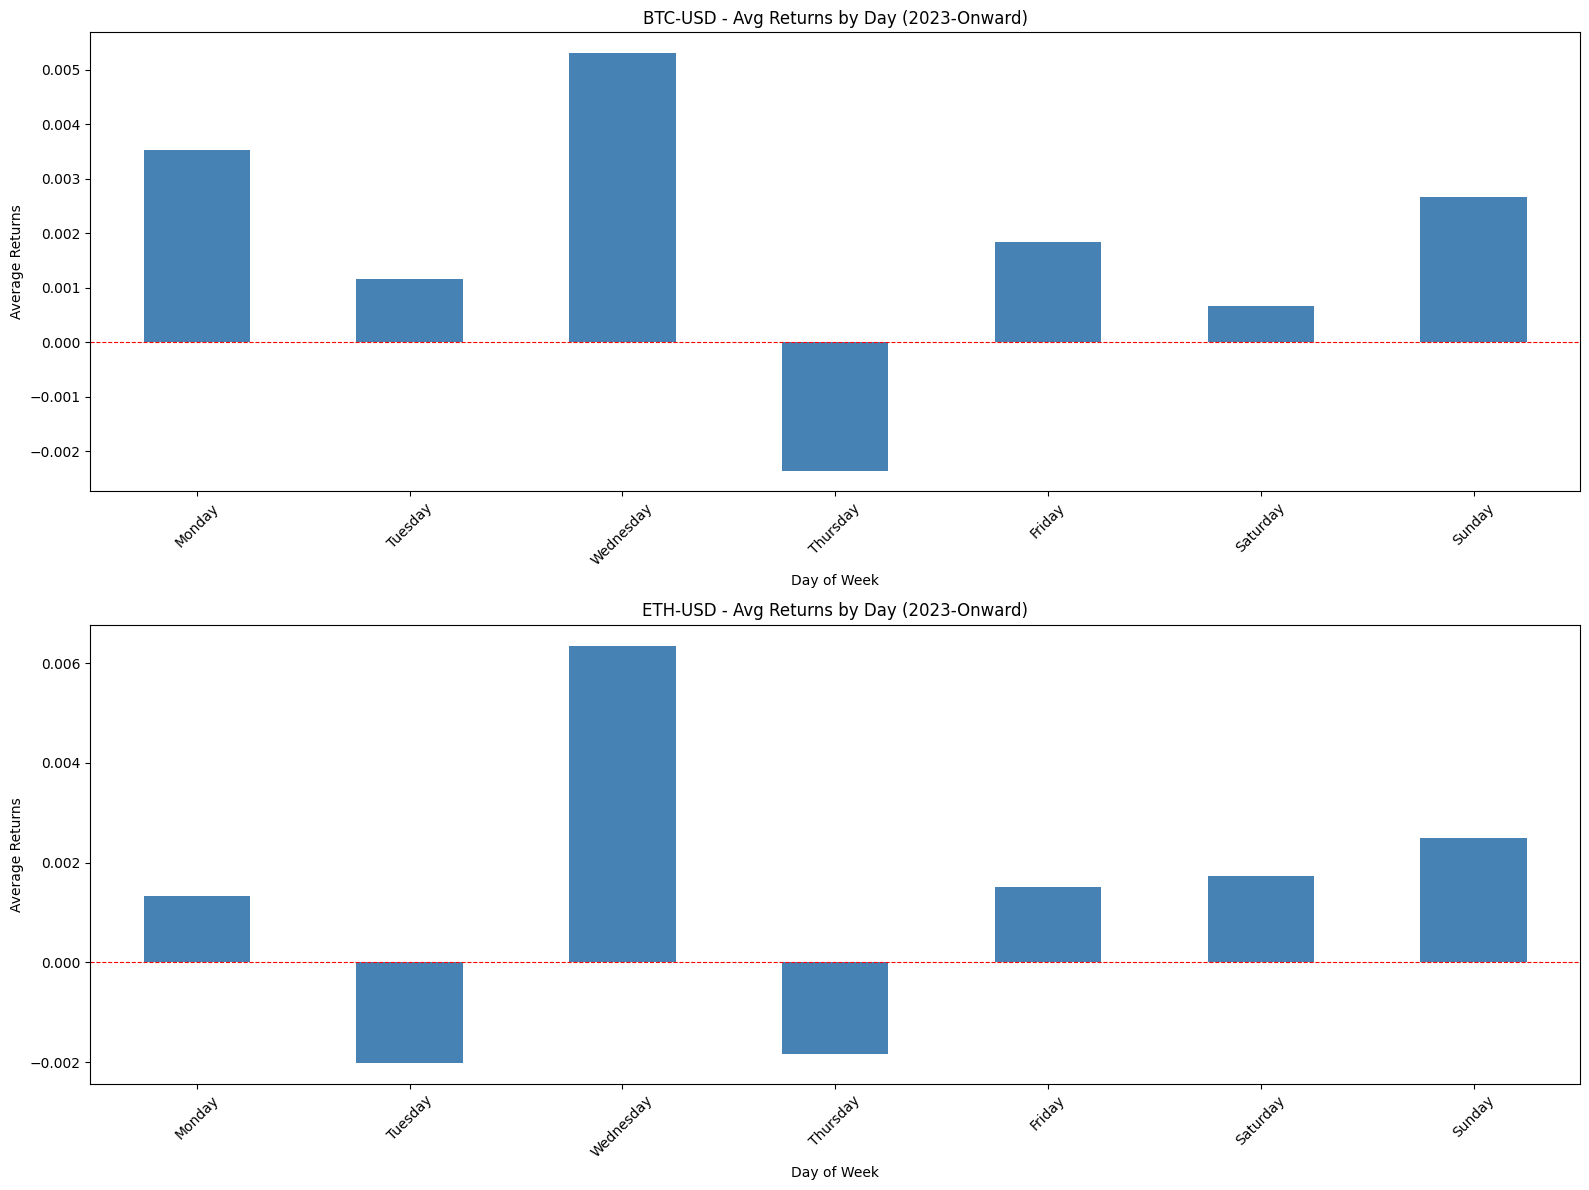

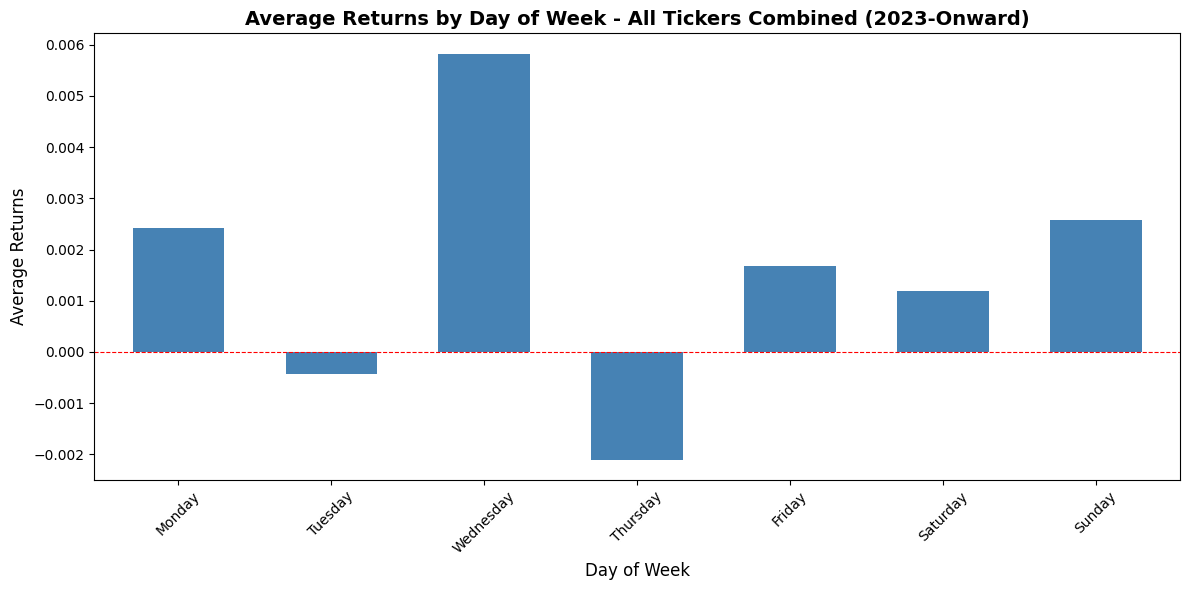

In [16]:
# Define time periods
periods = {
    '2020-2022': ('2020-01-01', '2022-12-31'),
    '2023-Onward': ('2023-01-01', '2025-12-31')
}

# Calculate average returns by day of week for each period
for period_name, (start_date, end_date) in periods.items():
    print(f"\n{'='*80}")
    print(f"Period: {period_name}")
    print(f"{'='*80}\n")
    
    # Filter data for this period
    period_data = data.loc[start_date:end_date]
    
    # Calculate returns by day of week for this period
    returns_by_day_period = pd.DataFrame(index=day_order)
    
    for ticker in TICKERS:
        # Get returns data for this ticker in this period
        returns_data_period = period_data['Returns'][ticker].copy()
        
        # Create a temporary DataFrame with returns and day of week
        temp_df_period = pd.DataFrame({
            'Returns': returns_data_period,
            'DayOfWeek': period_data[('DayOfWeek', 'DayOfWeek')]
        })
        
        # Calculate average returns by day of week
        avg_returns_period = temp_df_period.groupby('DayOfWeek')['Returns'].mean()
        
        # Add to results DataFrame
        returns_by_day_period[ticker] = avg_returns_period
    
    # Reorder rows to start with Monday
    returns_by_day_period = returns_by_day_period.reindex(day_order)
    
    # Create individual plots for each ticker
    fig, axes = plt.subplots(SUB_PLOTS_Y, SUB_PLOTS_X, figsize=(16, 12))
    axes = axes.flatten()
    
    for idx, ticker in enumerate(TICKERS):
        returns_by_day_period[ticker].plot(kind='bar', ax=axes[idx], 
                                           title=f'{ticker} - Avg Returns by Day ({period_name})', 
                                           color='steelblue')
        axes[idx].set_xlabel('Day of Week')
        axes[idx].set_ylabel('Average Returns')
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].axhline(y=0, color='red', linestyle='--', linewidth=0.8)
    
    plt.tight_layout()
    plt.show()
    
    # Create a combined plot showing the average returns across all tickers by day of week
    average_returns_all_period = returns_by_day_period.mean(axis=1)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    average_returns_all_period.plot(kind='bar', ax=ax, color='steelblue', width=0.6)
    ax.set_title(f'Average Returns by Day of Week - All Tickers Combined ({period_name})', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Day of Week', fontsize=12)
    ax.set_ylabel('Average Returns', fontsize=12)
    ax.axhline(y=0, color='red', linestyle='--', linewidth=0.8)
    ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

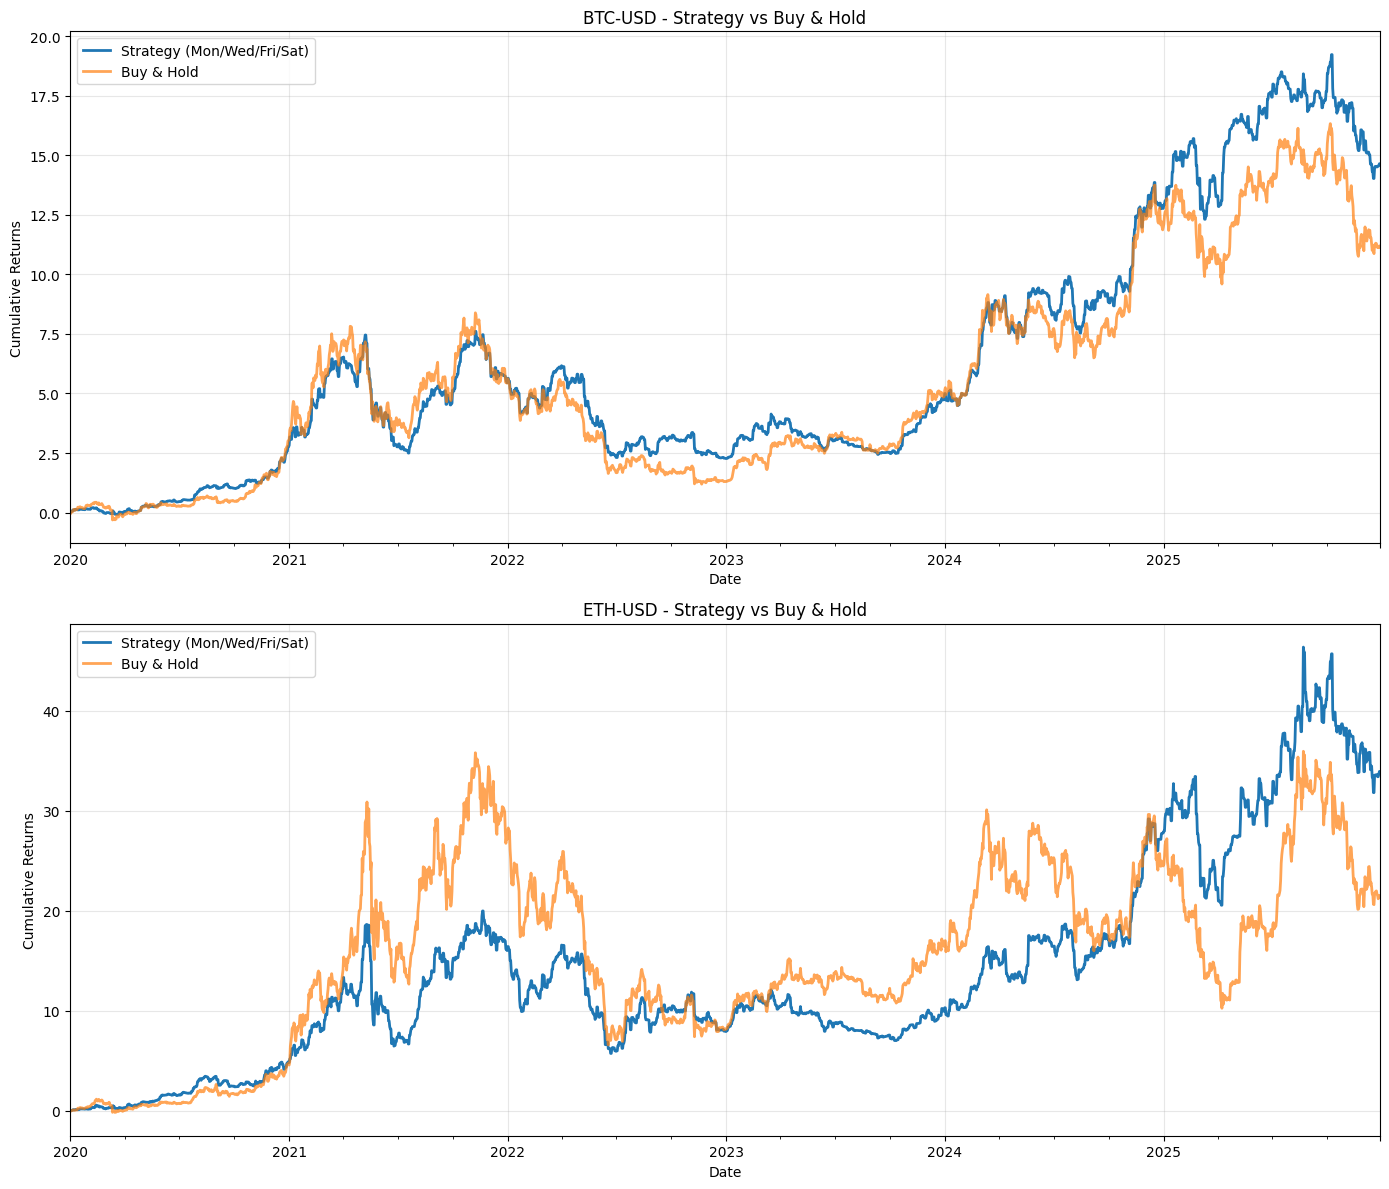


Strategy vs Buy & Hold Summary Statistics:
         Strategy Ann. Return  B&H Ann. Return  Strategy Ann. Vol  B&H Ann. Vol  Strategy Sharpe  B&H Sharpe  Strategy Max DD  B&H Max DD  Strategy Total Return  B&H Total Return
BTC-USD              0.565403         0.606229           0.463417      0.610018         1.220075    0.993789        -0.620543   -0.766346              14.642866         11.161838
ETH-USD              0.786152         0.857793           0.622019      0.817036         1.263871    1.049884        -0.678568   -0.793512              33.923181         21.411875


In [17]:
# Create a trading strategy that buys on Monday, Wednesday, Friday, and Saturday
trading_days = ['Monday', 'Wednesday', 'Friday', 'Saturday']

# Create a DataFrame to store strategy returns
strategy_returns = pd.DataFrame(index=data.index, columns=TICKERS)

for ticker in TICKERS:
    # Get the day of week for each date
    ticker_day = data[('DayOfWeek', 'DayOfWeek')]
    
    # Get returns for this ticker
    ticker_returns = data['Returns'][ticker].copy()
    
    # Apply strategy: only take returns on trading days, otherwise 0
    strategy_returns[ticker] = ticker_returns.where(ticker_day.isin(trading_days), 0)
    strategy_returns[ticker] = strategy_returns[ticker].fillna(0)

# Calculate cumulative returns for the strategy
strategy_cumulative = (1 + strategy_returns).cumprod() - 1

# Plot strategy vs buy & hold
fig, axes = plt.subplots(len(TICKERS), 1, figsize=(14, 6 * len(TICKERS)))
if len(TICKERS) == 1:
    axes = [axes]

for idx, ticker in enumerate(TICKERS):
    # Plot strategy cumulative returns
    strategy_cumulative[ticker].plot(ax=axes[idx], label='Strategy (Mon/Wed/Fri/Sat)', linewidth=2)
    
    # Plot buy & hold cumulative returns
    cumulative_returns[ticker].plot(ax=axes[idx], label='Buy & Hold', linewidth=2, alpha=0.7)
    
    axes[idx].set_title(f'{ticker} - Strategy vs Buy & Hold')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Cumulative Returns')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate summary statistics for the strategy
strategy_summary = pd.DataFrame(index=TICKERS)

for ticker in TICKERS:
    strat_returns = strategy_returns[ticker]
    bh_returns = data['Returns'][ticker]
    
    # Strategy metrics
    strat_annual_return = strat_returns.mean() * 365
    strat_annual_vol = strat_returns.std() * np.sqrt(365)
    strat_sharpe = strat_annual_return / strat_annual_vol
    
    strat_cumulative = (1 + strat_returns).cumprod()
    strat_running_max = strat_cumulative.cummax()
    strat_drawdown = (strat_cumulative - strat_running_max) / strat_running_max
    strat_max_drawdown = strat_drawdown.min()
    
    # Buy & Hold metrics
    bh_annual_return = bh_returns.mean() * 365
    bh_annual_vol = bh_returns.std() * np.sqrt(365)
    bh_sharpe = bh_annual_return / bh_annual_vol
    
    bh_cumulative = (1 + bh_returns).cumprod()
    bh_running_max = bh_cumulative.cummax()
    bh_drawdown = (bh_cumulative - bh_running_max) / bh_running_max
    bh_max_drawdown = bh_drawdown.min()
    
    # Total returns
    strat_total = strategy_cumulative[ticker].iloc[-1]
    bh_total = cumulative_returns[ticker].iloc[-1]
    
    # Store results
    strategy_summary.loc[ticker, 'Strategy Ann. Return'] = strat_annual_return
    strategy_summary.loc[ticker, 'B&H Ann. Return'] = bh_annual_return
    strategy_summary.loc[ticker, 'Strategy Ann. Vol'] = strat_annual_vol
    strategy_summary.loc[ticker, 'B&H Ann. Vol'] = bh_annual_vol
    strategy_summary.loc[ticker, 'Strategy Sharpe'] = strat_sharpe
    strategy_summary.loc[ticker, 'B&H Sharpe'] = bh_sharpe
    strategy_summary.loc[ticker, 'Strategy Max DD'] = strat_max_drawdown
    strategy_summary.loc[ticker, 'B&H Max DD'] = bh_max_drawdown
    strategy_summary.loc[ticker, 'Strategy Total Return'] = strat_total
    strategy_summary.loc[ticker, 'B&H Total Return'] = bh_total

print("\nStrategy vs Buy & Hold Summary Statistics:")
print(strategy_summary.to_string())

In [18]:
# Create an equally weighted portfolio strategy
# Calculate portfolio returns (equally weighted across all tickers)
portfolio_strategy_returns = strategy_returns.mean(axis=1)

# Calculate cumulative returns for portfolio
portfolio_strategy_cumulative = (1 + portfolio_strategy_returns).cumprod()

# Calculate portfolio metrics
# Strategy metrics
portfolio_strat_annual_return = portfolio_strategy_returns.mean() * 365
portfolio_strat_annual_vol = portfolio_strategy_returns.std() * np.sqrt(365)
portfolio_strat_sharpe = portfolio_strat_annual_return / portfolio_strat_annual_vol

portfolio_strat_running_max = portfolio_strategy_cumulative.cummax()
portfolio_strat_drawdown = (portfolio_strategy_cumulative - portfolio_strat_running_max) / portfolio_strat_running_max
portfolio_strat_max_drawdown = portfolio_strat_drawdown.min()

portfolio_strat_total = portfolio_strategy_cumulative.iloc[-1] - 1

# Calculate time period
start = data.index[0]
end = data.index[-1]
num_years = (end - start).days / 365.25

# Print formatted results
print("=" * 60)
print("BACKTEST RESULTS")
print("=" * 60)
print("Strategy:")
print(" * Equally weighted portfolio across all tickers")
print(" * Long only on Monday, Wednesday, Friday, Saturday")
print(f"Period: {start.strftime('%Y-%m')} to {end.strftime('%Y-%m')}")
print(f"Number of years: {num_years:.2f}")
print("-" * 60)
print(f"Total Return: {portfolio_strat_total * 100:.2f}%")
print(f"Annualized Return: {portfolio_strat_annual_return * 100:.2f}%")
print(f"Annualized Volatility: {portfolio_strat_annual_vol * 100:.2f}%")
print(f"Sharpe Ratio: {portfolio_strat_sharpe:.3f}")
print(f"Maximum Drawdown: {portfolio_strat_max_drawdown * 100:.2f}%")
print("=" * 60)

BACKTEST RESULTS
Strategy:
 * Equally weighted portfolio across all tickers
 * Long only on Monday, Wednesday, Friday, Saturday
Period: 2020-01 to 2025-12
Number of years: 5.99
------------------------------------------------------------
Total Return: 2482.75%
Annualized Return: 67.58%
Annualized Volatility: 51.62%
Sharpe Ratio: 1.309
Maximum Drawdown: -63.80%
